# 畳み込みニューラル・ネットワーク

前のユニットでは、クラス定義を使って多層ニューラルネットワークを定義する方法を学びましたが、それらのネットワークは一般的なもので、コンピュータビジョンのタスクに特化したものではありませんでした。このユニットでは、コンピュータ・ビジョンに特化して設計された**畳み込みニューラルネットワーク（CNN）**について学びます。

コンピュータビジョンは、一般的な分類とは異なります。なぜなら、写真の中の特定のオブジェクトを見つけようとするとき、私たちは画像をスキャンして、特定の**パターン**とその組み合わせを探しているからです。例えば、猫を探すときには、まず横線を探し、それがひげになり、ひげのある組み合わせによって猫の写真であることがわかるのです。あるパターンの相対的な位置と存在が重要であり、画像上の正確な位置ではない。

パターンを抽出するために、**convolutional filters**という概念を使います。しかしその前に、前のユニットで定義したすべての依存関係と関数をロードしましょう。

In [1]:
import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np

from pytorchcv import load_mnist, train, plot_results, plot_convolution, display_dataset
load_mnist(batch_size=128)

## Convolutional filters

畳み込みフィルターとは、画像の各ピクセルの上を走り、隣接するピクセルの加重平均を計算する小さな窓のことです。

畳み込みフィルタは、重み係数の行列で定義されます。それでは、MNISTの手書き数字に2種類の畳み込みフィルタを適用した例を見てみましょう。

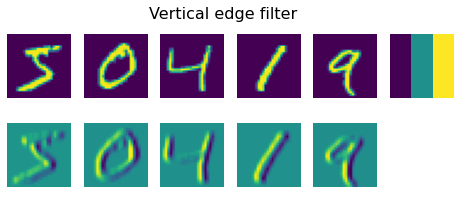

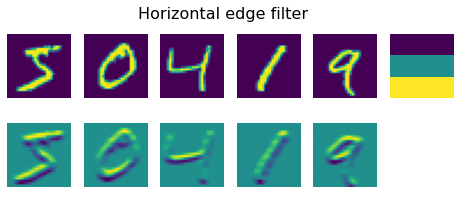

In [2]:
plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter')

最初のフィルターは、**垂直エッジフィルター**と呼ばれ、以下の行列で定義されます。
$$
\left(
    \begin{matrix}
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
    \end{matrix}
\right)
$$
このフィルターが比較的均一なピクセルフィールドを通過するときには、すべての値の合計は0になりますが、画像の垂直方向のエッジに遭遇すると、高いスパイク値が生成されます。上の画像では、垂直方向のエッジは高い値と低い値で表され、水平方向のエッジは平均化されているのはこのためです。

水平方向のエッジフィルターをかけると、逆に水平方向のラインが増幅され、垂直方向は平均化されます。

従来のコンピュータビジョンでは、複数のフィルタを画像に適用して特徴量を生成し、それを機械学習アルゴリズムで分類器を構築していました。しかし、深層学習では、分類問題を解決するために、最適な畳み込みフィルターを **学習** するネットワークを構築します。

そのために導入したのが**畳み込み層**です。

## 畳み込み層

畳み込み層は、`nn.Conv2d`構文を使って定義します。以下のように指定する必要があります。

* `in_channels` - 入力チャンネルの数．ここでは，グレースケール画像を扱うので，入力チャンネル数は 1 です．
* `out_channels` - 使用するフィルタの数．ここでは9種類のフィルタを使用します。これにより、どのフィルタがシナリオに最適なのかをネットワークが探索する機会が多くなります。
* `kernel_size` は，スライディングウィンドウのサイズである．通常，3x3 または 5x5 のフィルタが使用される．

最も単純なCNNは1つの畳み込み層を持つ。入力サイズが28x28の場合、9個の5x5フィルタを適用すると、最終的に9x24x24のテンソルができあがります（長さ5のスライディング・インターバルが28ピクセルに収まる位置は24箇所しかないので、空間的なサイズは小さくなります）。

畳み込みの後、9x24x24のテンソルを5184サイズの1つのベクトルに平坦化し、線形層を追加して、10のクラスを生成しています。また、層間には活性化関数「relu」を使用しています。

In [3]:
class OneConv(nn.Module):
    def __init__(self):
        super(OneConv, self).__init__()
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(5184,10)

    def forward(self, x):
        x = nn.functional.relu(self.conv(x))
        x = self.flatten(x)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = OneConv()

summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
OneConv                                  --                        --
├─Conv2d: 1-1                            [1, 9, 24, 24]            234
├─Flatten: 1-2                           [1, 5184]                 --
├─Linear: 1-3                            [1, 10]                   51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
Total mult-adds (M): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.21
Estimated Total Size (MB): 0.25

このネットワークの学習可能なパラメータは約50kであるのに対し，完全に連結された多層ネットワークでは約80kであることがわかります．畳み込みネットワークの方が一般化しやすいため、小さなデータセットでも良い結果を得ることができます。.

Epoch  0, Train acc=0.943, Val acc=0.973, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.978, Val acc=0.977, Train loss=0.001, Val loss=0.001
Epoch  2, Train acc=0.984, Val acc=0.976, Train loss=0.000, Val loss=0.001
Epoch  3, Train acc=0.987, Val acc=0.978, Train loss=0.000, Val loss=0.001
Epoch  4, Train acc=0.989, Val acc=0.973, Train loss=0.000, Val loss=0.001


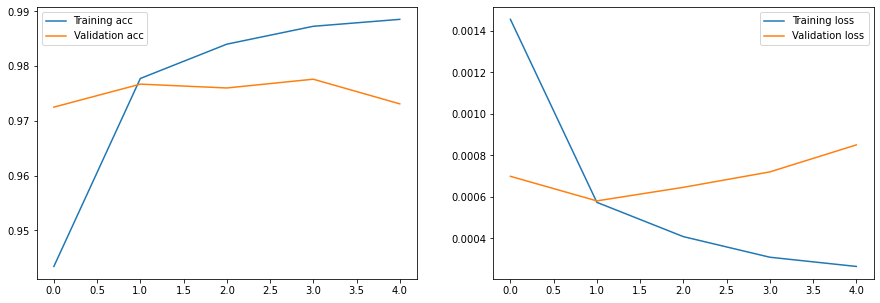

In [4]:
hist = train(net, train_loader, test_loader, epochs=5)
plot_results(hist)

ご覧のように、前のユニットの完全に接続されたネットワークに比べて、より高い精度を、より速く達成することができます。

また、学習した畳み込み層の重みを可視化することで、何が起こっているのかをより理解することができます。

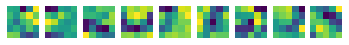

In [5]:
fig,ax = plt.subplots(1,9)
with torch.no_grad():
    p = next(net.conv.parameters())
    for i,x in enumerate(p):
        ax[i].imshow(x.detach().cpu()[0,...])
        ax[i].axis('off')

斜め方向のストロークを認識できそうなフィルターもあれば、かなり適当なフィルターもあることがわかります。

## マルチレイヤーCNNとプーリングレイヤー

最初の畳み込み層では、水平線や垂直線などの原始的なパターンを探しますが、その上にさらに畳み込み層を重ねることで、原始的な形状などのより高度なパターンを探すことができます。そして、さらに畳み込み層を重ねることで、それらの図形を画像の一部に合成し、最終的に分類しようとしている物体にまで仕上げることができます。

その際には、画像の空間的なサイズを小さくするという方法もあります。3x3のスライドウィンドウ内に水平方向のストークがあることを検出したら、どのピクセルで発生したかはそれほど重要ではありません。そのため、画像のサイズを「縮小」することができます。これには、**pooling layer**を使用します。

* **Average Pooling** スライディングウィンドウ（例えば、2x2ピクセル）を取り、ウィンドウ内の値の平均を計算します。
* **Max Pooling** ウィンドウを最大値に置き換えます。マックスプーリングの考え方は，スライディングウィンドウの中に特定のパターンが存在することを検出することです。

したがって、典型的なCNNでは、いくつかの畳み込み層を設け、その間にプーリング層を設けて画像のサイズを小さくします。また、フィルターの数も増やします。なぜなら、パターンが高度になればなるほど、探さなければならない興味深い組み合わせの可能性が増えるからです。

![プーリング層を持つ複数の畳み込み層を示した画像](./images/cnn-pyramid.png)

このアーキテクチャは、空間的な次元が減少し、機能/フィルタの次元が増加することから、**ピラミッド・アーキテクチャ**とも呼ばれます。

In [6]:
class MultiLayerCNN(nn.Module):
    def __init__(self):
        super(MultiLayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(10, 20, 5)
        self.fc = nn.Linear(320,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 320)
        x = nn.functional.log_softmax(self.fc(x),dim=1)
        return x

net = MultiLayerCNN()
summary(net,input_size=(1,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MultiLayerCNN                            --                        --
├─Conv2d: 1-1                            [1, 10, 24, 24]           260
├─MaxPool2d: 1-2                         [1, 10, 12, 12]           --
├─Conv2d: 1-3                            [1, 20, 8, 8]             5,020
├─MaxPool2d: 1-4                         [1, 20, 4, 4]             --
├─Linear: 1-5                            [1, 10]                   3,210
Total params: 8,490
Trainable params: 8,490
Non-trainable params: 0
Total mult-adds (M): 0.47
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.03
Estimated Total Size (MB): 0.09

この定義について、いくつかの点に注意してください。
* `Flatten` レイヤを使用する代わりに、`forward` 関数内のテンソルを `view` 関数を使用してフラット化しています。平坦化層は学習可能な重みを持たないため、クラス内に別の層のインスタンスを作成する必要はありません。
* このモデルでは、プーリング層のインスタンスを1つだけ使用していますが、これは学習可能なパラメータが含まれていないためで、この1つのインスタンスは効果的に再利用することができます。
* 学習可能なパラメータの数（～8.5K）は、これまでの例に比べて劇的に少なくなっています。これは、一般的に畳み込み層はパラメータが少なく、最終的に高密度の層を適用する前の画像の次元が大幅に減少するためです。パラメータの数が少ないと、データセットのサイズが小さくてもオーバーフィッティングを防ぐことができるため、モデルに良い影響を与えます。

In [7]:
hist = train(net, train_loader, test_loader, epochs=5)

Epoch  0, Train acc=0.948, Val acc=0.979, Train loss=0.001, Val loss=0.001
Epoch  1, Train acc=0.982, Val acc=0.984, Train loss=0.000, Val loss=0.000
Epoch  2, Train acc=0.985, Val acc=0.983, Train loss=0.000, Val loss=0.000
Epoch  3, Train acc=0.986, Val acc=0.983, Train loss=0.000, Val loss=0.000
Epoch  4, Train acc=0.986, Val acc=0.983, Train loss=0.000, Val loss=0.001


ここで注目していただきたいのは、1層だけの場合よりも高い精度で、しかも1〜2回のエポックで、より高速に処理できることです。つまり、洗練されたネットワーク・アーキテクチャでは、何が起こっているのかを把握し、画像から一般的なパターンを抽出するために必要なデータ数が非常に少なくなるということです。

## CIFAR-10データセットの実際の画像で試す

手書きの数字を認識する問題は、一見おもちゃのように見えますが、ここからはもっと本格的な問題に取り組みます。[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html)と呼ばれる、さまざまな物体の写真を集めたより高度なデータセットを調べてみましょう。

In [8]:
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=14, shuffle=True)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=14, shuffle=False)
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

170499072it [19:32, 145417.85it/s]                               


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


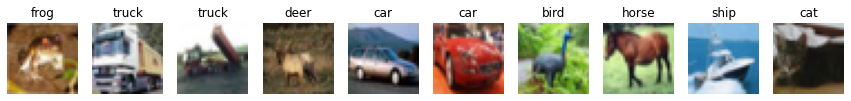

In [9]:
display_dataset(trainset,classes=classes)

CIFAR-10用の有名なアーキテクチャは[LeNet](https://en.wikipedia.org/wiki/LeNet)と呼ばれるもので、*Yann LeCun*氏によって提案されました。このアーキテクチャは、上述した原理と同じですが、主な違いは、入力カラーチャンネルが1ではなく3であることです。

出力活性化関数として`log_softmax`を使わず、最後の完全連結層の出力を返すようにしています。この場合、モデルを最適化するために `CrossEntropyLoss` 損失関数を使用することができます。

In [10]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.conv3 = nn.Conv2d(16,120,5)
        self.flat = nn.Flatten()
        self.fc1 = nn.Linear(120,64)
        self.fc2 = nn.Linear(64,10)

    def forward(self, x):
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = nn.functional.relu(self.conv3(x))
        x = self.flat(x)
        x = nn.functional.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = LeNet()

summary(net,input_size=(1,3,32,32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    --                        --
├─Conv2d: 1-1                            [1, 6, 28, 28]            456
├─MaxPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─MaxPool2d: 1-4                         [1, 16, 5, 5]             --
├─Conv2d: 1-5                            [1, 120, 1, 1]            48,120
├─Flatten: 1-6                           [1, 120]                  --
├─Linear: 1-7                            [1, 64]                   7,744
├─Linear: 1-8                            [1, 10]                   650
Total params: 59,386
Trainable params: 59,386
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.01
Forward/backward pass size (MB): 0.05
Params size (MB): 0.24
Estimated Total Size (MB): 0.30

Training this network properly will take significant amount of time, and should preferably be done on GPU-enabled compute.

In [11]:
opt = torch.optim.SGD(net.parameters(),lr=0.001,momentum=0.9)
hist = train(net, trainloader, testloader, epochs=3, optimizer=opt, loss_fn=nn.CrossEntropyLoss())

Epoch  0, Train acc=0.246, Val acc=0.390, Train loss=0.145, Val loss=0.118


3エポックの学習で達成できた精度は、それほど高くないように見えます。しかし、ブラインド推測では10%の精度しか得られず、我々の問題はMNISTの桁分類よりもかなり難しいことを覚えておいてください。このような短い学習時間で50%以上の精度を得ることができたのは、良い成果だと思います。

## 覚えておくべき重要点

このユニットでは、コンピュータ・ビジョン・ニューラル・ネットワークの主要なコンセプトである「畳み込みネットワーク」を学びました。画像分類、物体検出、さらには画像生成ネットワークを実現する現実のアーキテクチャは、すべてCNNをベースにしていますが、層が増え、トレーニングのトリックも追加されています。

## 演習問題

1. 畳み込み層と密な層のパラメータ数はどのように相関するのか？

- コンボリューショナル・レイヤーはパラメータが多い
- コンボリューション層のパラメータが少ない
  > 正解

2. 入力画像のサイズが3x320x200の場合、16個のフィルタを持つ5x5の畳み込み層を適用した後のテンソルのサイズはどうなるか？

- 16x316x196
  > 正解
- 3x316x196
- 16x3x320x200
- 48x320x200

3. マルチレイヤーCNNで空間次元を大幅に減らすには、どのレイヤーを適用すればいいのか？

- Convolution
- Flatten
- MaxPooling
  > 正解

4. ネットワークの畳み込みベースと最終的な線形分類器の間に使用される層は？

- Convolution
- Flatten
  > 正解
- MaxPooling
- Sigmoid
